In [6]:
# %%
# ============================================
# 0. SETUP & CONFIGURATION
# ============================================
import os
import warnings
import dask
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)
dask.config.set({"dataframe.query-planning": True})


In [7]:

# --- VISUALIZATION SETTINGS (WHITE THEME) ---
# 1. Enforce White Background for Seaborn
sns.set_style("white")
sns.set_context("paper", font_scale=1.2)

# 2. Enforce White Background for Matplotlib (Global)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['axes.grid'] = False  # Clean look

# 3. Configure Scanpy
sc.set_figure_params(dpi=150, figsize=(8, 8), facecolor='white')

# Define Paths
DATA_PATH = "../../data/Kidney_ST/GSE211785_7_13_23_slide0_annotated_iPTsubclusters.h5ad"
OUTPUT_DIR = "../../analysis/moduleScore"  # Updated Path

# Create Output Directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Outputs will be saved to: {OUTPUT_DIR}")

# --- HELPER FUNCTION FOR SAVING PLOTS ---


def save_plot(filename_base):
    """Saves the current matplotlib figure as PDF and PNG."""
    # Save PNG (High Res Raster)
    png_path = os.path.join(OUTPUT_DIR, f"{filename_base}.png")
    plt.savefig(png_path, dpi=300, bbox_inches='tight', facecolor='white')

    # Save PDF (Vector)
    pdf_path = os.path.join(OUTPUT_DIR, f"{filename_base}.pdf")
    plt.savefig(pdf_path, format='pdf', bbox_inches='tight', facecolor='white')

    print(f"Saved: {filename_base}")


Outputs will be saved to: ../../analysis/moduleScore


In [8]:

# %%
# ============================================
# 1. DATA LOADING
# ============================================
print("Loading data...")
adata = sc.read_h5ad(DATA_PATH)

# CRITICAL FIX: Convert coordinates to Numpy Array
if hasattr(adata.obsm['spatial'], 'to_numpy'):
    print("Fixing spatial coordinates format...")
    adata.obsm['spatial'] = adata.obsm['spatial'].to_numpy()
elif not isinstance(adata.obsm['spatial'], np.ndarray):
    adata.obsm['spatial'] = np.array(adata.obsm['spatial'])

print("Data Loaded Successfully.")


Loading data...


Fixing spatial coordinates format...
Data Loaded Successfully.


In [9]:

# %%
# ============================================
# 2. DEFINE MODULES & SCORING (LITERATURE BASED)
# ============================================
# These are curated from Hallmarks (MSigDB) and Kidney-Specific Literature
hallmark_genes = {
    'Angiogenesis': ['VEGFA', 'KDR', 'FLT1', 'PECAM1', 'VWF', 'ANGPT2'],
    'Apoptosis': ['CASP3', 'BAX', 'FAS', 'TP53', 'BAD', 'BCL2L11'],
    'Cell_cycle': ['MKI67', 'PCNA', 'TOP2A', 'CDK1', 'CCNB1', 'MCM6'],
    'Differentiation': ['PAX8', 'HNF4A', 'LRP2', 'SLC34A1', 'UMOD'],
    'DNA_repair': ['ATM', 'ATR', 'BRCA1', 'PARP1', 'RAD51', 'XRCC1'],
    'DNA_damage': ['H2AX', 'DDB2', 'GADD45A', 'CDKN1A', 'BTG2'],
    'EMT': ['VIM', 'FN1', 'CDH2', 'ZEB1', 'SNAI1', 'SPP1', 'COL1A1'],
    'Hypoxia': ['HIF1A', 'SLC2A1', 'CA9', 'VEGFA', 'LDHA', 'PGK1'],
    'Inflammation': ['CCL2', 'IL6', 'TNF', 'NFKB1', 'ICAM1', 'CXCL10', 'CD68'],
    'Invasion_Metastasis': ['MMP9', 'MMP2', 'CTSB', 'PLAU', 'S100A4'],
    'Proliferation': ['MKI67', 'CCND1', 'MYC', 'E2F1', 'AURKA'],
    'Quiescence': ['CDKN1B', 'HES1', 'GAS1', 'NR4A1'],
    'Stemness': ['PROM1', 'ALDH1A1', 'SOX9', 'CD24', 'CD44', 'KRT19'],
    # Custom Functional Categories
    'Dev_Regulation': ['PAX8', 'HOXA9', 'CRB2', 'BICC1', 'CYFIP2', 'EFHD1', 'HNF4A', 'HNF1A'],
    'Metabolism': ['ALDOB', 'ALDH8A1', 'NAT8B', 'ACSF2', 'BDH2', 'PEPD', 'SHMT1', 'GPX3', 'FBP1'],
    'Transport': ['SLC5A10', 'SLC17A3', 'SLC2A9', 'SLC9A3', 'KCNJ15', 'CUBN', 'LRP2', 'AQP1']
}

print("--- Calculating Scores ---")
valid_categories = []

for category, genes in hallmark_genes.items():
    # Find available genes
    available = [g for g in genes if g in adata.var_names]
    # Remove duplicates
    available = list(set(available))

    if len(available) >= 1:
        print(f"✅ {category}: Scoring based on {len(available)} genes")
        sc.tl.score_genes(adata, gene_list=available, score_name=category)
        valid_categories.append(category)
    else:
        print(f"❌ {category}: No genes found in panel.")


--- Calculating Scores ---
✅ Angiogenesis: Scoring based on 6 genes


✅ Apoptosis: Scoring based on 4 genes
✅ Cell_cycle: Scoring based on 3 genes
✅ Differentiation: Scoring based on 2 genes
✅ DNA_repair: Scoring based on 4 genes
✅ DNA_damage: Scoring based on 1 genes
✅ EMT: Scoring based on 5 genes
✅ Hypoxia: Scoring based on 4 genes
✅ Inflammation: Scoring based on 7 genes
✅ Invasion_Metastasis: Scoring based on 3 genes
✅ Proliferation: Scoring based on 3 genes
❌ Quiescence: No genes found in panel.
✅ Stemness: Scoring based on 4 genes
❌ Dev_Regulation: No genes found in panel.
✅ Metabolism: Scoring based on 1 genes
✅ Transport: Scoring based on 2 genes


In [10]:

# %%
# ============================================
# 3. SPATIAL MAPS (ALL MODULES)
# ============================================
print("Generating Spatial Module Maps...")

# Filter for modules that were actually calculated
available_states = [s for s in valid_categories if s in adata.obs.columns]

if available_states:
    # We use a loop to plot them in chunks if there are too many,
    # but here we plot all in a large grid
    sc.pl.spatial(
        adata,
        color=available_states + ['type'],
        title=available_states + ['Condition'],
        spot_size=0.01,
        # Use 'magma' or 'plasma' for high contrast on white
        cmap='magma',
        wspace=0.3,
        ncols=4,  # Grid layout
        show=False
    )
    save_plot("1_Spatial_Maps_All_Modules")
    plt.close()
    
    # --- SPECIFIC COMPARISON PLOT ---
    # Plot Inflammation vs EMT (The classic "Fibrosis" story)
    sc.pl.spatial(
        adata,
        color=['Inflammation', 'EMT', 'type'],
        title=['Inflammation (Immune)', 'EMT (Fibrosis)', 'Condition'],
        cmap='magma',
        spot_size=0.01,
        wspace=0.3,
        ncols=3,
        show=False
    )
    save_plot("2_Spatial_Comparison_Inflammation_EMT")
    plt.close()


Generating Spatial Module Maps...


Saved: 1_Spatial_Maps_All_Modules
Saved: 2_Spatial_Comparison_Inflammation_EMT


In [11]:

# %%
# ============================================
# 4. CORRELATION MATRIX (FUNCTIONAL STATES)
# ============================================
print("Generating Correlation Matrix...")

# Prepare data
score_df = adata.obs[valid_categories].copy()
corr_matrix = score_df.corr(method='spearman')

plt.figure(figsize=(12, 12))
g = sns.clustermap(
    corr_matrix,
    cmap='coolwarm',     # Red = Positive, Blue = Negative
    center=0,
    annot=True,          # Show numbers
    fmt=".2f",
    figsize=(12, 12),
    dendrogram_ratio=(.15, .15),
    cbar_pos=(0, .2, .03, .4),
    tree_kws={'colors': 'black'}  # Black lines for white theme
)

# Fix axis labels to be black
plt.setp(g.ax_heatmap.get_xticklabels(), color='black')
plt.setp(g.ax_heatmap.get_yticklabels(), color='black')

g.ax_heatmap.set_title("Correlation of Functional States",
                       y=1.2, color='black', fontsize=16)

save_plot("3_Correlation_Matrix_Functional_States")
plt.close()


Generating Correlation Matrix...
Saved: 3_Correlation_Matrix_Functional_States


<Figure size 1800x1800 with 0 Axes>

In [12]:

# %%
# ============================================
# 5. VIOLIN PLOTS (DIFFERENTIAL REGULATION)
# ============================================
print("Generating Violin Plots...")

# Melt data for FacetGrid
melted_df = pd.melt(adata.obs, id_vars=['type'], value_vars=valid_categories,
                    var_name='Pathway', value_name='Score')

# Setup the FacetGrid
g = sns.catplot(
    data=melted_df,
    x='type',           # X-axis: Condition
    y='Score',          # Y-axis: Score
    col='Pathway',      # Separate plot for each Pathway
    col_wrap=5,         # 5 plots per row
    kind='violin',
    sharey=False,       # Each plot gets its own scale
    height=4,
    aspect=0.8,
    palette={'Healthy': '#bdbdbd', 'Disease': '#cb181d'},  # Grey vs Red
    cut=0,
    inner=None
)

# Overlay dots (Strip Plot)
g.map_dataframe(
    sns.stripplot,
    x='type', y='Score',
    color='black', alpha=0.1, size=1.5, jitter=True
)

# Titles
g.set_titles("{col_name}", size=12, fontweight='bold')
g.set_axis_labels("", "Module Score")
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Differential Regulation of Functional States', fontsize=18)

save_plot("4_Violin_Plots_Differential_Regulation")
plt.close()


Generating Violin Plots...
Saved: 4_Violin_Plots_Differential_Regulation


In [13]:

# %%
# ============================================
# 6. DOT PLOT (SUMMARY VIEW)
# ============================================
print("Generating Dot Plot...")

sc.pl.dotplot(
    adata,
    var_names=valid_categories,
    groupby='type',
    standard_scale='var',    # Scale 0-1
    cmap='Reds',
    dot_max=0.8,
    dendrogram=True,
    title="Functional State Activation Summary",
    show=False
)
save_plot("5_DotPlot_Functional_Summary")
plt.close()


Generating Dot Plot...
Saved: 5_DotPlot_Functional_Summary


In [14]:

# %%
# ============================================
# 7. TRAJECTORY ANALYSIS (PSEUDOTIME)
# ============================================
print("Running Trajectory Analysis...")

# A. Setup Root (Healthy Differentiated Cell)
if 'Differentiation' in adata.obs.columns:
    # Find the "Most Healthy" cell (High Diff, Healthy Condition)
    candidates = np.flatnonzero(
        (adata.obs['type'] == 'Healthy') &
        (adata.obs['Differentiation'] >
         adata.obs['Differentiation'].quantile(0.9))
    )
    if len(candidates) > 0:
        adata.uns['iroot'] = candidates[0]

        # B. Calculate Pseudotime
        # PCA -> Neighbors -> Diffmap -> DPT
        sc.pp.pca(adata)
        sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca')
        sc.tl.diffmap(adata)
        sc.tl.dpt(adata)  # Computes 'dpt_pseudotime'

        # C. Spatial Trajectory Map
        sc.pl.spatial(
            adata,
            color=['dpt_pseudotime', 'type'],
            title=['Disease Trajectory (0=Healthy -> 1=Disease)', 'Condition'],
            cmap='viridis',
            spot_size=0.01,
            wspace=0.3,
            show=False
        )
        save_plot("6_Spatial_Trajectory_Pseudotime")
        plt.close()

        # D. Dynamics Plot (Line Graph)
        # Create plotting dataframe
        traj_df = adata.obs[['dpt_pseudotime',
                             'Differentiation', 'EMT', 'Stemness', 'type']].copy()
        traj_df = traj_df.sort_values('dpt_pseudotime')

        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot smooth trend lines
        sns.regplot(data=traj_df, x='dpt_pseudotime', y='Differentiation',
                    scatter=False, label='Identity (Diff)', color='green', ax=ax)
        sns.regplot(data=traj_df, x='dpt_pseudotime', y='EMT',
                    scatter=False, label='Fibrosis (EMT)', color='red', ax=ax)
        sns.regplot(data=traj_df, x='dpt_pseudotime', y='Stemness',
                    scatter=False, label='Stemness', color='blue', ax=ax)

        ax.set_xlabel("Pseudotime (Disease Progression)", fontsize=12)
        ax.set_ylabel("Module Score", fontsize=12)
        ax.set_title(
            "The Path of Fibrosis: Loss of Identity drives EMT", fontsize=14)
        ax.legend()
        sns.despine()

        save_plot("7_Trajectory_Dynamics_LinePlot")
        plt.close()
    else:
        print("Could not find suitable root cell for trajectory analysis.")
else:
    print("Differentiation score missing; skipping trajectory.")


Running Trajectory Analysis...
Saved: 6_Spatial_Trajectory_Pseudotime
Saved: 7_Trajectory_Dynamics_LinePlot


In [15]:

# %%
# ============================================
# 8. DENSITY PLOT (IDENTITY MAINTENANCE)
# ============================================
score_to_plot = 'Dev_Regulation'

if score_to_plot in adata.obs.columns:
    print(f"Generating Density Plot for {score_to_plot}...")

    data_df = adata.obs[['x_slide_mm',
                         'y_slide_mm', score_to_plot, 'type']].copy()

    # Filter for top 20% cells (The "Strong" cells)
    threshold = data_df[score_to_plot].quantile(0.80)
    high_scoring_cells = data_df[data_df[score_to_plot] > threshold]

    if len(high_scoring_cells) > 10:
        g = sns.FacetGrid(high_scoring_cells, col="type", height=6, aspect=1)
        g.map_dataframe(
            sns.kdeplot,
            x="x_slide_mm",
            y="y_slide_mm",
            fill=True,
            cmap="mako",  # Blue-Green density
            thresh=0.05,
            alpha=0.8
        )

        g.fig.suptitle(
            f"Density of Cells Maintaining '{score_to_plot}' Identity", y=1.05, fontsize=16)

        # Invert Y for slide coordinates
        for ax in g.axes.flat:
            ax.invert_yaxis()
            ax.grid(False)

        save_plot("8_Density_Identity_Maintenance")
        plt.close()

print("\n--- ANALYSIS COMPLETE. ALL PLOTS SAVED TO ../../analysis/moduleScore ---")



--- ANALYSIS COMPLETE. ALL PLOTS SAVED TO ../../analysis/moduleScore ---


In [4]:
# Suppress warnings before importing packages
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import dask
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Configure dask before importing packages that use it
dask.config.set({"dataframe.query-planning": True})

# Now import packages


AttributeError: partially initialized module 'pandas' from '/mnt/home3/miska/nm667/miniconda3/envs/cosmaxSpatial/lib/python3.13/site-packages/pandas/__init__.py' has no attribute '_pandas_datetime_CAPI' (most likely due to a circular import)

In [2]:
# 1. Load the data
print("Loading data...")
adata = sc.read_h5ad(
    "../../data/Kidney_ST/GSE211785_7_13_23_slide0_annotated_iPTsubclusters.h5ad")

# 2. CRITICAL FIX: Convert coordinates to Numpy Array
# (You must run this every time you load this file!)
if hasattr(adata.obsm['spatial'], 'to_numpy'):
    print("Fixing spatial coordinates format...")
    adata.obsm['spatial'] = adata.obsm['spatial'].to_numpy()
elif not isinstance(adata.obsm['spatial'], np.ndarray):
    adata.obsm['spatial'] = np.array(adata.obsm['spatial'])

# 3. Ensure spatial coordinates are ready for plotting
print("Spatial coordinates ready")
print(f"  Shape: {adata.obsm['spatial'].shape}")
print(f"  Type: {type(adata.obsm['spatial'])}")

print("Data loaded!")


Loading data...


Fixing spatial coordinates format...
Spatial coordinates ready
  Shape: (558601, 2)
  Type: <class 'numpy.ndarray'>
Data loaded!


In [3]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Define the Categories with Primary (Your Figure) and Rescue (Common CosMx) genes
gene_categories = {
    'Dev_Regulation': {
        'primary': ['PAX8', 'HOXA9', 'CRB2', 'BICC1', 'CYFIP2', 'EFHD1'],
        # Master regulators often in panels
        'rescue': ['HNF4A', 'HNF1A', 'WT1', 'LHX1']
    },
    'Metabolism': {
        'primary': ['ALDOB', 'ALDH8A1', 'NAT8B', 'ACSF2', 'BDH2', 'PEPD', 'SHMT1'],
        # High-abundance PT metabolic enzymes
        'rescue': ['GPX3', 'FBP1', 'PCK1', 'GLUL', 'ASS1']
    },
    'Transport': {
        'primary': ['SLC5A10', 'SLC17A3', 'SLC2A9', 'SLC9A3', 'KCNJ15', 'CUBN'],
        # Major PT transporters (Megalin, NPT2a, AQP1)
        'rescue': ['LRP2', 'SLC34A1', 'AQP1', 'SLC22A6', 'SLC22A8']
    },
    'Structural_Other': {
        'primary': ['LGALS2', 'RGL3', 'TM7SF3', 'ARMC7', 'OCIAD2'],
        'rescue': ['VIM', 'CDH16', 'SPP1']  # Ksp-Cadherin and injury markers
    }
}

# 2. Smart Filter: Build the final list based on what exists in YOUR data
final_pathways = {}

print("--- Smart Gene Selection ---")
for category, gene_lists in gene_categories.items():
    # Check Primary Genes
    found_primary = [g for g in gene_lists['primary'] if g in adata.var_names]
    # Check Rescue Genes
    found_rescue = [g for g in gene_lists['rescue'] if g in adata.var_names]

    # Combine them (prioritizing primary)
    combined_genes = list(set(found_primary + found_rescue))

    if combined_genes:
        final_pathways[category] = combined_genes
        print(f"\n✅ {category}: Found {len(combined_genes)} genes")
        print(f"   Matches from Figure: {found_primary}")
        if not found_primary:
            print(
                f"   ⚠️ No primary genes found. Using relatives: {found_rescue}")
    else:
        print(f"\n❌ {category}: No primary OR rescue genes found in this panel.")


--- Smart Gene Selection ---

✅ Dev_Regulation: Found 2 genes
   Matches from Figure: []
   ⚠️ No primary genes found. Using relatives: ['WT1', 'LHX1']

✅ Metabolism: Found 2 genes
   Matches from Figure: []
   ⚠️ No primary genes found. Using relatives: ['GPX3', 'GLUL']

✅ Transport: Found 2 genes
   Matches from Figure: ['CUBN']

✅ Structural_Other: Found 2 genes
   Matches from Figure: []
   ⚠️ No primary genes found. Using relatives: ['VIM', 'SPP1']


In [4]:
# Calculate Module Scores
for category, genes in final_pathways.items():
    print(f"Scoring {category} with {len(genes)} genes...")
    sc.tl.score_genes(adata, gene_list=genes, score_name=category)


Scoring Dev_Regulation with 2 genes...
Scoring Metabolism with 2 genes...
Scoring Transport with 2 genes...
Scoring Structural_Other with 2 genes...


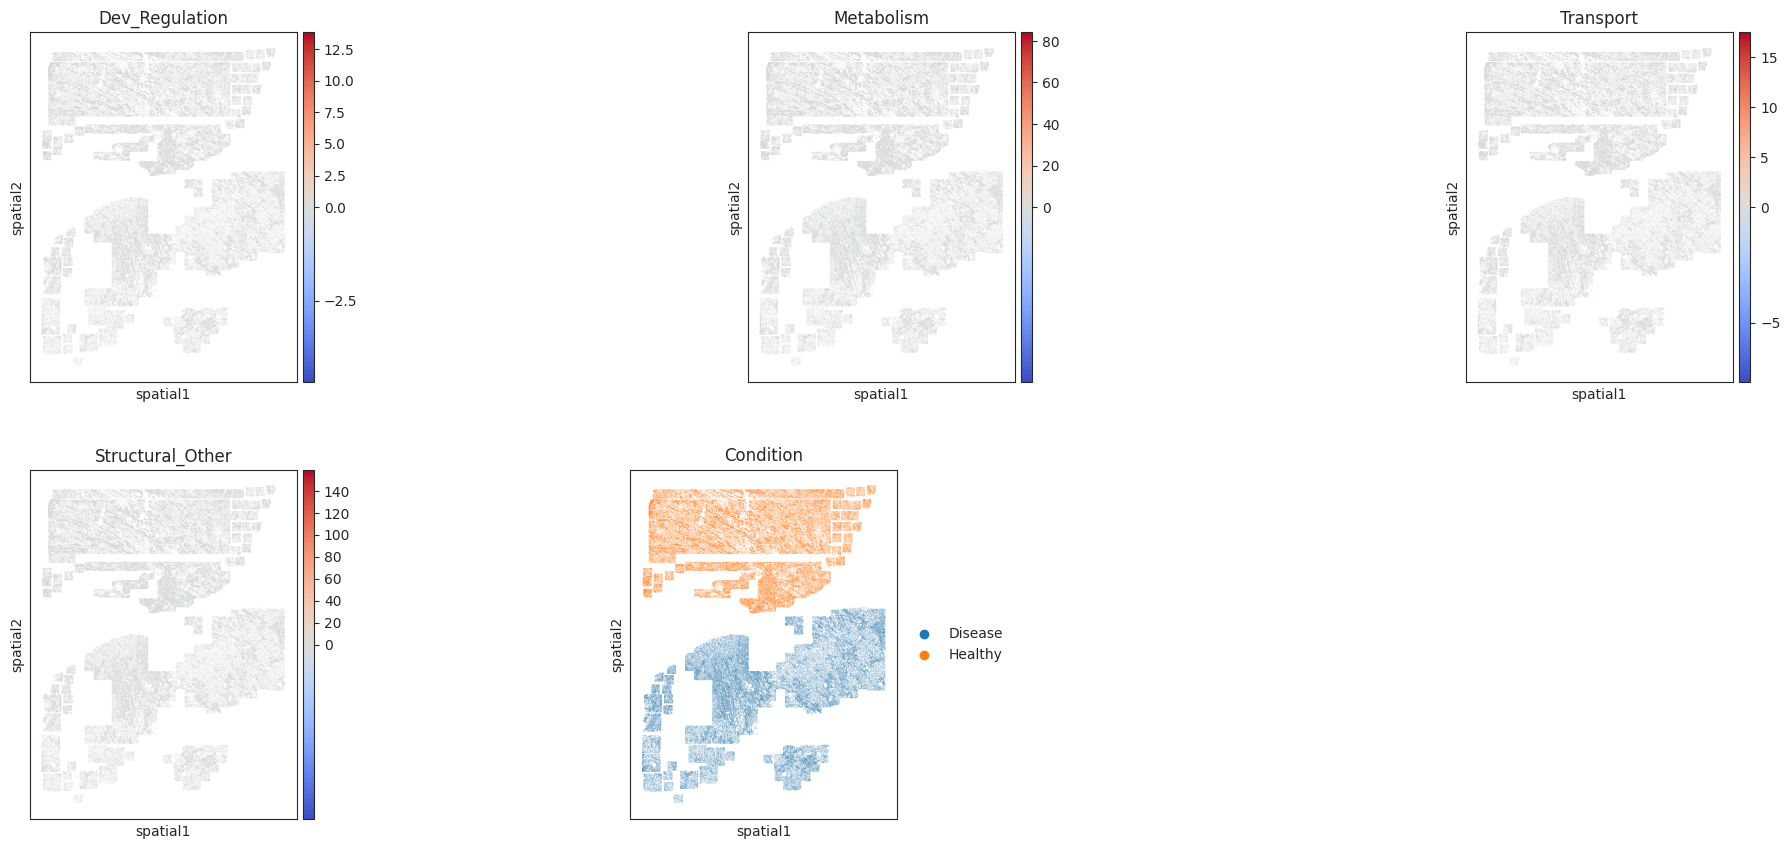

In [5]:


# Reset to default style to remove any lingering dark mode settings
sns.set_style("white")
# Visualize all successful categories
plots_to_show = list(final_pathways.keys())

if plots_to_show:
    sc.pl.spatial(
        adata,
        color=plots_to_show + ['type'],
        title=plots_to_show + ['Condition'],
        cmap='coolwarm',     # Red = High, Blue = Low
        spot_size=0.01,
        wspace=0.3,
        vcenter=0,
        ncols=3
    )
    plt.show()


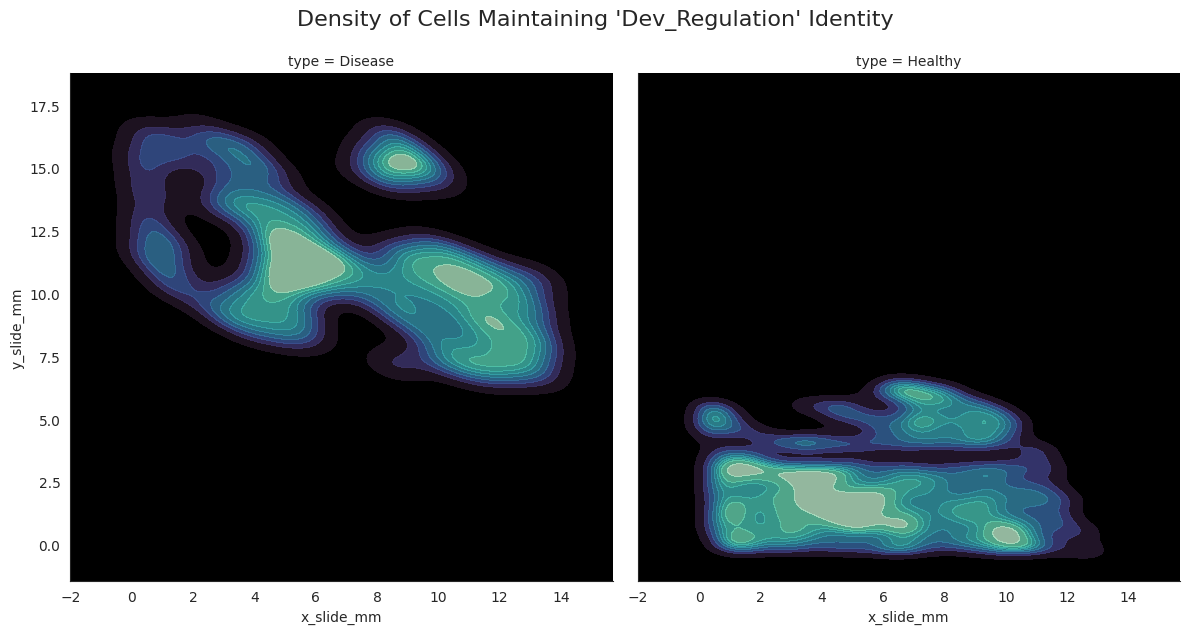

In [6]:
# Focus on the Developmental/Regulatory Signal
score_to_plot = 'Dev_Regulation'

if score_to_plot in adata.obs.columns:
    # 1. Extract Data
    data_df = adata.obs[['x_slide_mm',
                         'y_slide_mm', score_to_plot, 'type']].copy()

    # 2. Filter for the Top 20% "High Identity" cells
    # (These are the healthy cells maintaining their proper state)
    threshold = data_df[score_to_plot].quantile(0.80)
    high_scoring_cells = data_df[data_df[score_to_plot] > threshold]

    # 3. Plot Density Contours
    g = sns.FacetGrid(high_scoring_cells, col="type", height=6, aspect=1)
    g.map_dataframe(
        sns.kdeplot,
        x="x_slide_mm",
        y="y_slide_mm",
        fill=True,
        # Mako: Black/Blue to Green (Good for "Identity" visualization)
        cmap="mako",
        thresh=0.05,
        alpha=0.8
    )

    g.fig.suptitle(
        f"Density of Cells Maintaining '{score_to_plot}' Identity", y=1.05, fontsize=16)

    # Style formatting
    for ax in g.axes.flat:
        ax.invert_yaxis()
        ax.set_facecolor('black')
        ax.grid(False)

    plt.show()
else:
    print(f"Could not generate density plot: '{score_to_plot}' has no genes.")


In [7]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 1. Define the Literature-Based Gene Sets
# These are curated from Hallmarks (MSigDB) and Kidney-Specific Literature
hallmark_genes = {
    'Angiogenesis': ['VEGFA', 'KDR', 'FLT1', 'PECAM1', 'VWF', 'ANGPT2'],
    'Apoptosis': ['CASP3', 'BAX', 'FAS', 'TP53', 'BAD', 'BCL2L11'],
    'Cell_cycle': ['MKI67', 'PCNA', 'TOP2A', 'CDK1', 'CCNB1', 'MCM6'],
    # Kidney specific identity
    'Differentiation': ['PAX8', 'HNF4A', 'LRP2', 'SLC34A1', 'UMOD'],
    'DNA_repair': ['ATM', 'ATR', 'BRCA1', 'PARP1', 'RAD51', 'XRCC1'],
    'DNA_damage': ['H2AX', 'DDB2', 'GADD45A', 'CDKN1A', 'BTG2'],
    # Key for Fibrosis
    'EMT': ['VIM', 'FN1', 'CDH2', 'ZEB1', 'SNAI1', 'SPP1', 'COL1A1'],
    'Hypoxia': ['HIF1A', 'SLC2A1', 'CA9', 'VEGFA', 'LDHA', 'PGK1'],
    'Inflammation': ['CCL2', 'IL6', 'TNF', 'NFKB1', 'ICAM1', 'CXCL10', 'CD68'],
    # Combined for robustness
    'Invasion_Metastasis': ['MMP9', 'MMP2', 'CTSB', 'PLAU', 'S100A4'],
    'Proliferation': ['MKI67', 'CCND1', 'MYC', 'E2F1', 'AURKA'],
    'Quiescence': ['CDKN1B', 'HES1', 'GAS1', 'NR4A1'],
    # Stem/Progenitor markers
    'Stemness': ['PROM1', 'ALDH1A1', 'SOX9', 'CD24', 'CD44', 'KRT19']
}

# 2. Filter & Score
print("--- Calculating Hallmark Scores ---")
valid_categories = []

for category, genes in hallmark_genes.items():
    # Find available genes
    available = [g for g in genes if g in adata.var_names]

    if len(available) >= 1:
        print(
            f"✅ {category}: Scoring based on {len(available)} genes ({available[:3]}...)")
        sc.tl.score_genes(adata, gene_list=available, score_name=category)
        valid_categories.append(category)
    else:
        print(f"❌ {category}: No genes found in panel.")


--- Calculating Hallmark Scores ---
✅ Angiogenesis: Scoring based on 6 genes (['VEGFA', 'KDR', 'FLT1']...)
✅ Apoptosis: Scoring based on 4 genes (['CASP3', 'BAX', 'FAS']...)
✅ Cell_cycle: Scoring based on 3 genes (['MKI67', 'PCNA', 'TOP2A']...)


✅ Differentiation: Scoring based on 2 genes (['LRP2', 'UMOD']...)
✅ DNA_repair: Scoring based on 4 genes (['ATM', 'ATR', 'BRCA1']...)
✅ DNA_damage: Scoring based on 1 genes (['CDKN1A']...)
✅ EMT: Scoring based on 5 genes (['VIM', 'FN1', 'SNAI1']...)
✅ Hypoxia: Scoring based on 4 genes (['HIF1A', 'SLC2A1', 'VEGFA']...)
✅ Inflammation: Scoring based on 7 genes (['CCL2', 'IL6', 'TNF']...)
✅ Invasion_Metastasis: Scoring based on 3 genes (['MMP9', 'MMP2', 'S100A4']...)
✅ Proliferation: Scoring based on 3 genes (['MKI67', 'CCND1', 'MYC']...)
❌ Quiescence: No genes found in panel.
✅ Stemness: Scoring based on 4 genes (['SOX9', 'CD24', 'CD44']...)


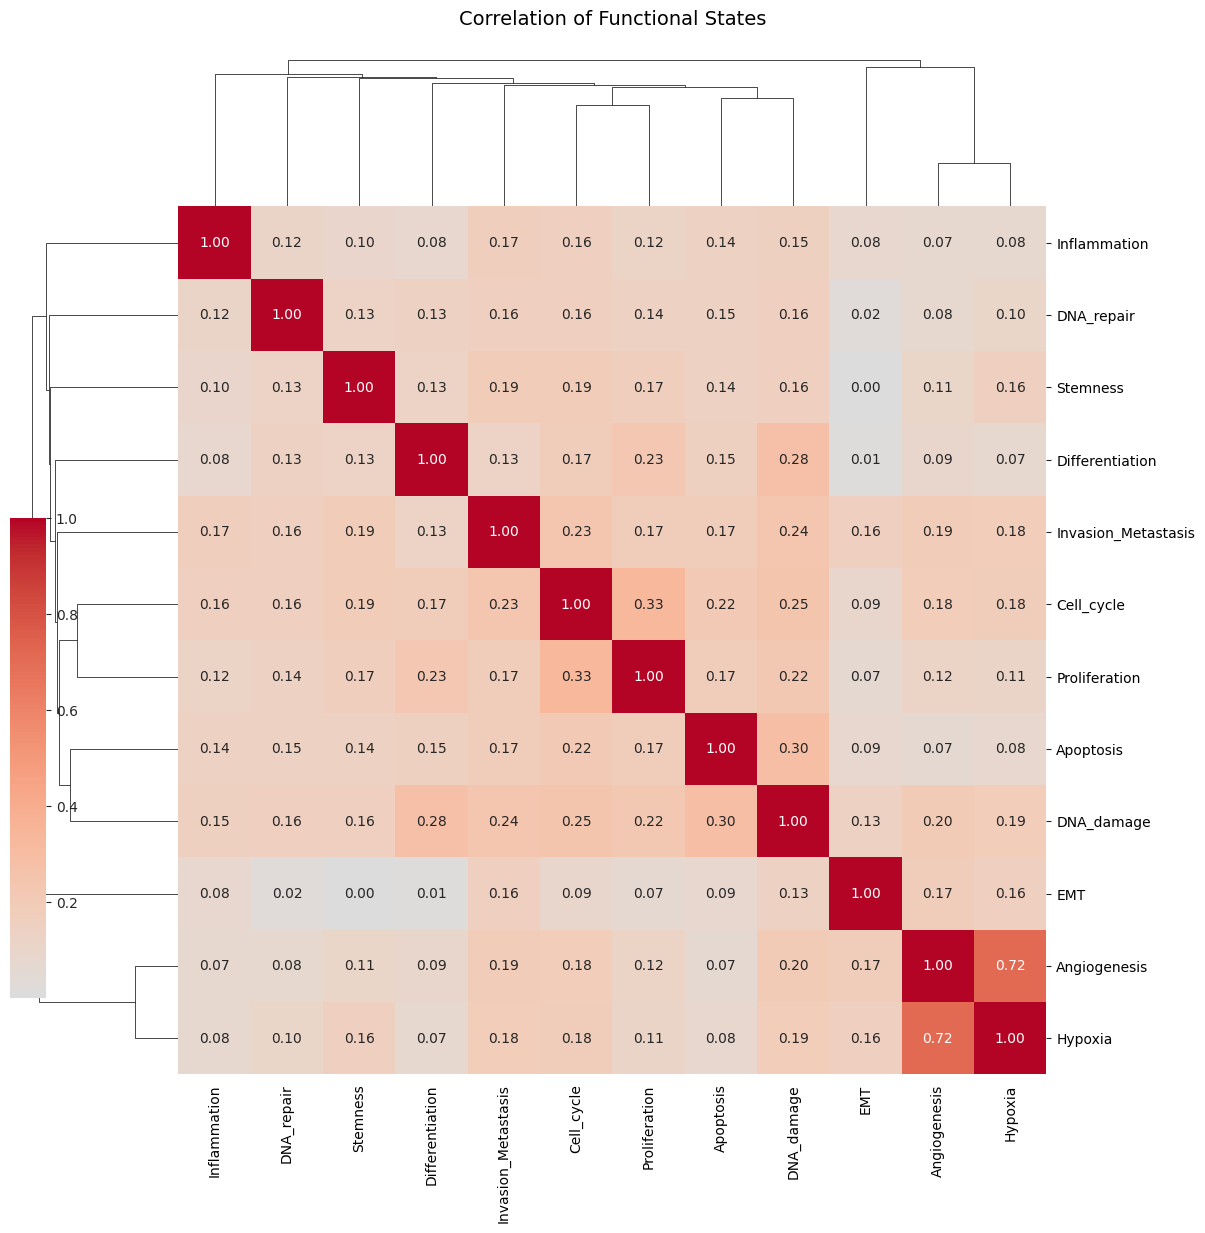

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
score_df = adata.obs[valid_categories].copy()
corr_matrix = score_df.corr(method='spearman')


g = sns.clustermap(
    corr_matrix,
    cmap='coolwarm',     # Red = Positive, Blue = Negative
    center=0,
    annot=True,          # Show numbers
    fmt=".2f",
    figsize=(12, 12),
    dendrogram_ratio=(.15, .15),
    cbar_pos=(0, .2, .03, .4),

    # Text colors for white background
    tree_kws={'colors': 'black'}  # Make the tree lines black
)

# Fix axis labels to be black
plt.setp(g.ax_heatmap.get_xticklabels(), color='black')
plt.setp(g.ax_heatmap.get_yticklabels(), color='black')

# Title
g.ax_heatmap.set_title("Correlation of Functional States",
                       y=1.2, color='black', fontsize=14)

plt.show()


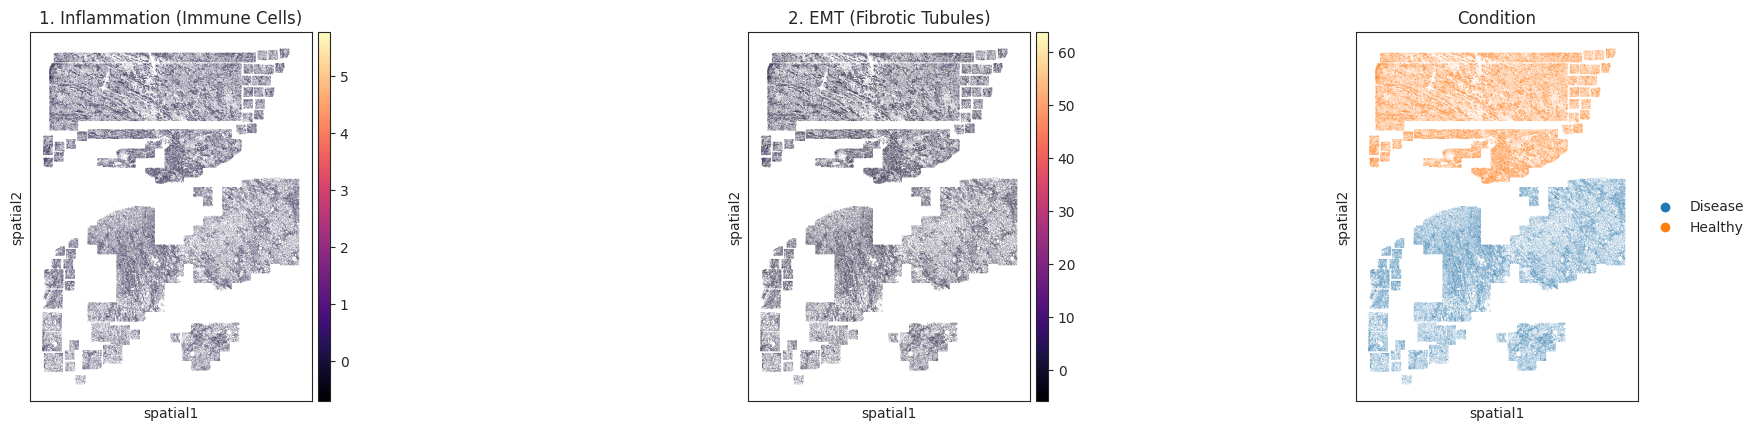

In [9]:
import scanpy as sc
import matplotlib.pyplot as plt

# Compare the two distinct populations spatially
sc.pl.spatial(
    adata,
    # Plot Inflammation (Immune) next to EMT (Tubule)
    color=['Inflammation', 'EMT', 'type'],
    title=['1. Inflammation (Immune Cells)',
           '2. EMT (Fibrotic Tubules)', 'Condition'],
    cmap='magma',
    spot_size=0.01,
    wspace=0.3,
    ncols=3
)
plt.show()


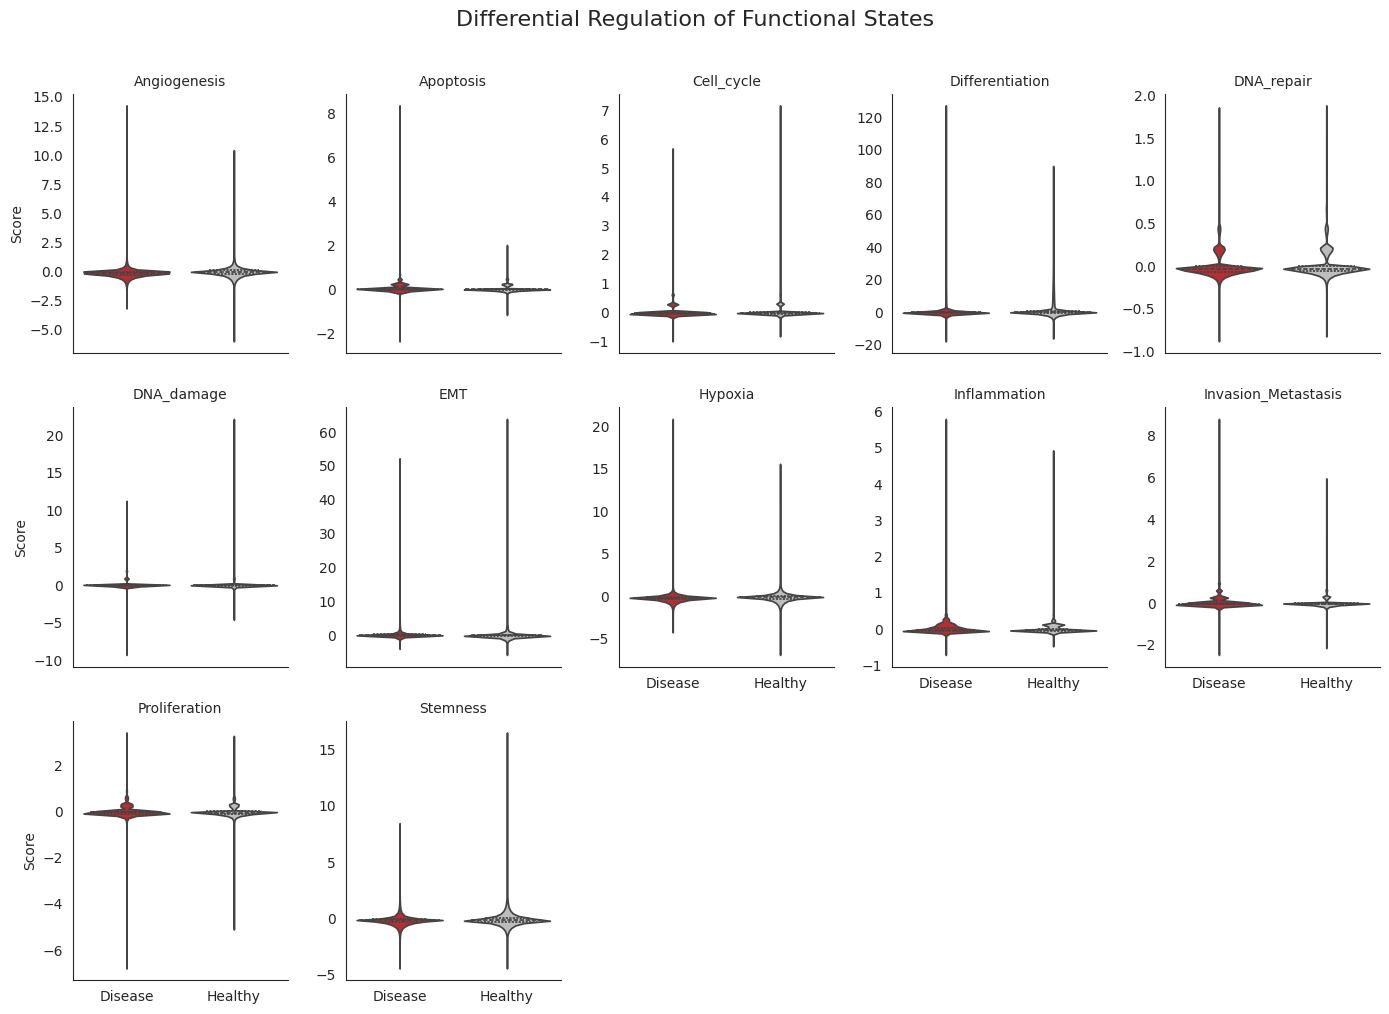

In [10]:

# Melt data (same as before)
melted_df = pd.melt(adata.obs, id_vars=['type'], value_vars=valid_categories,
                    var_name='Pathway', value_name='Score')

# 1. Setup the FacetGrid (Grid of plots)
g = sns.catplot(
    data=melted_df,
    x='type',           # X-axis is now just Condition
    y='Score',
    col='Pathway',      # Make a separate plot for each Pathway
    col_wrap=5,         # 5 plots per row
    kind='violin',      # Plot type
    sharey=False,       # <--- CRITICAL: Lets each plot have its own scale
    height=3.5,
    aspect=0.8,
    palette={'Healthy': '#bdbdbd', 'Disease': '#cb181d'},
    cut=0,
    inner='quart'
)

# 2. Clean up titles and labels
g.set_titles("{col_name}")  # Title of each subplot is just the Pathway name
g.set_axis_labels("", "Score")

# 3. Add a global title
plt.subplots_adjust(top=0.9)  # Make room at the top
g.fig.suptitle('Differential Regulation of Functional States', fontsize=16)

plt.show()


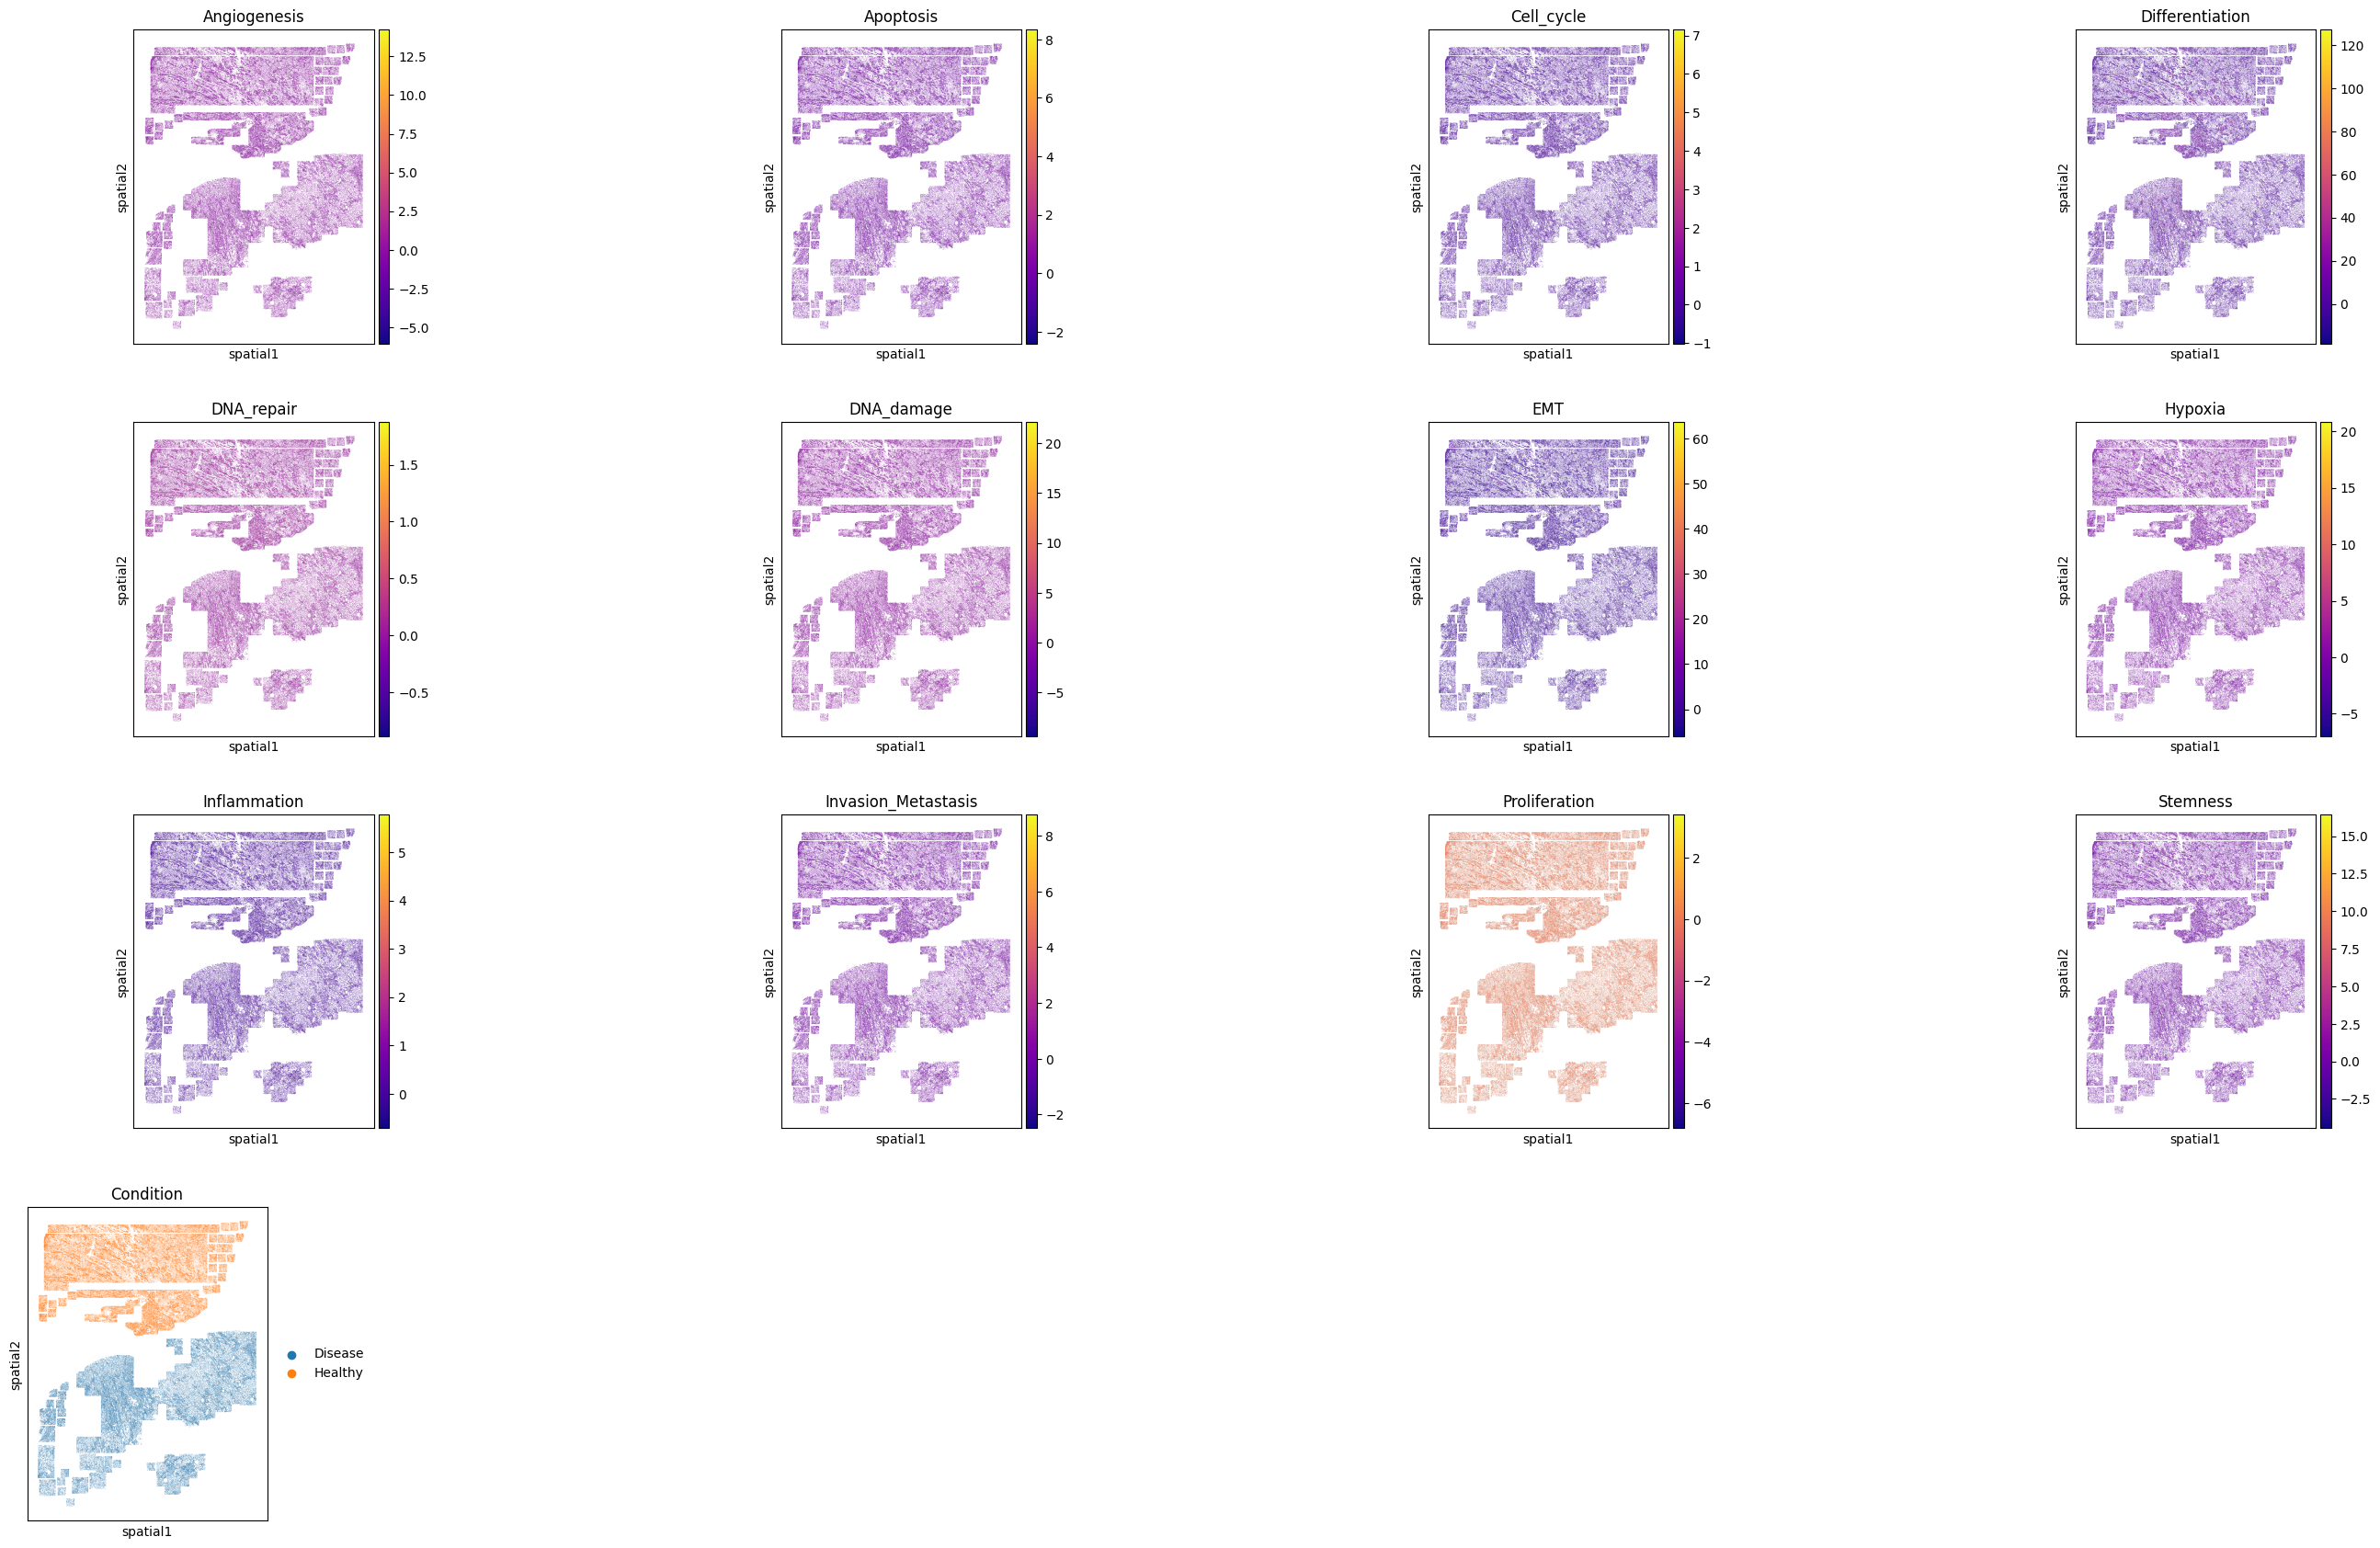

In [13]:
import scanpy as sc
import matplotlib.pyplot as plt

# 1. Define the list of Functional States you calculated
# (These must match the keys you used in sc.tl.score_genes)
functional_states = [
    'Angiogenesis', 'Apoptosis', 'Cell_cycle', 'Differentiation',
    'DNA_repair', 'DNA_damage', 'EMT', 'Hypoxia',
    'Inflammation', 'Invasion_Metastasis', 'Proliferation',
    'Quiescence', 'Stemness'
]

# 2. Filter: Only plot the ones that were successfully calculated
# (This prevents a KeyError if a category had 0 genes and wasn't created)
available_states = [s for s in functional_states if s in adata.obs.columns]

# 3. Plot them using your preferred style
if available_states:
    sc.pl.spatial(
        adata,
        # Add 'type' to compare Health vs Disease
        color=available_states + ['type'],
        title=available_states + ['Condition'],
        spot_size=0.01,
        cmap='plasma',      # Glowing colors (Yellow/Orange = High Activity)
        wspace=0.3,         # Space between panels
        ncols=4             # Arrange in a grid of 4 columns
    )
    plt.show()
else:
    print("No functional state scores found in adata.obs. Did you run Step 1?")


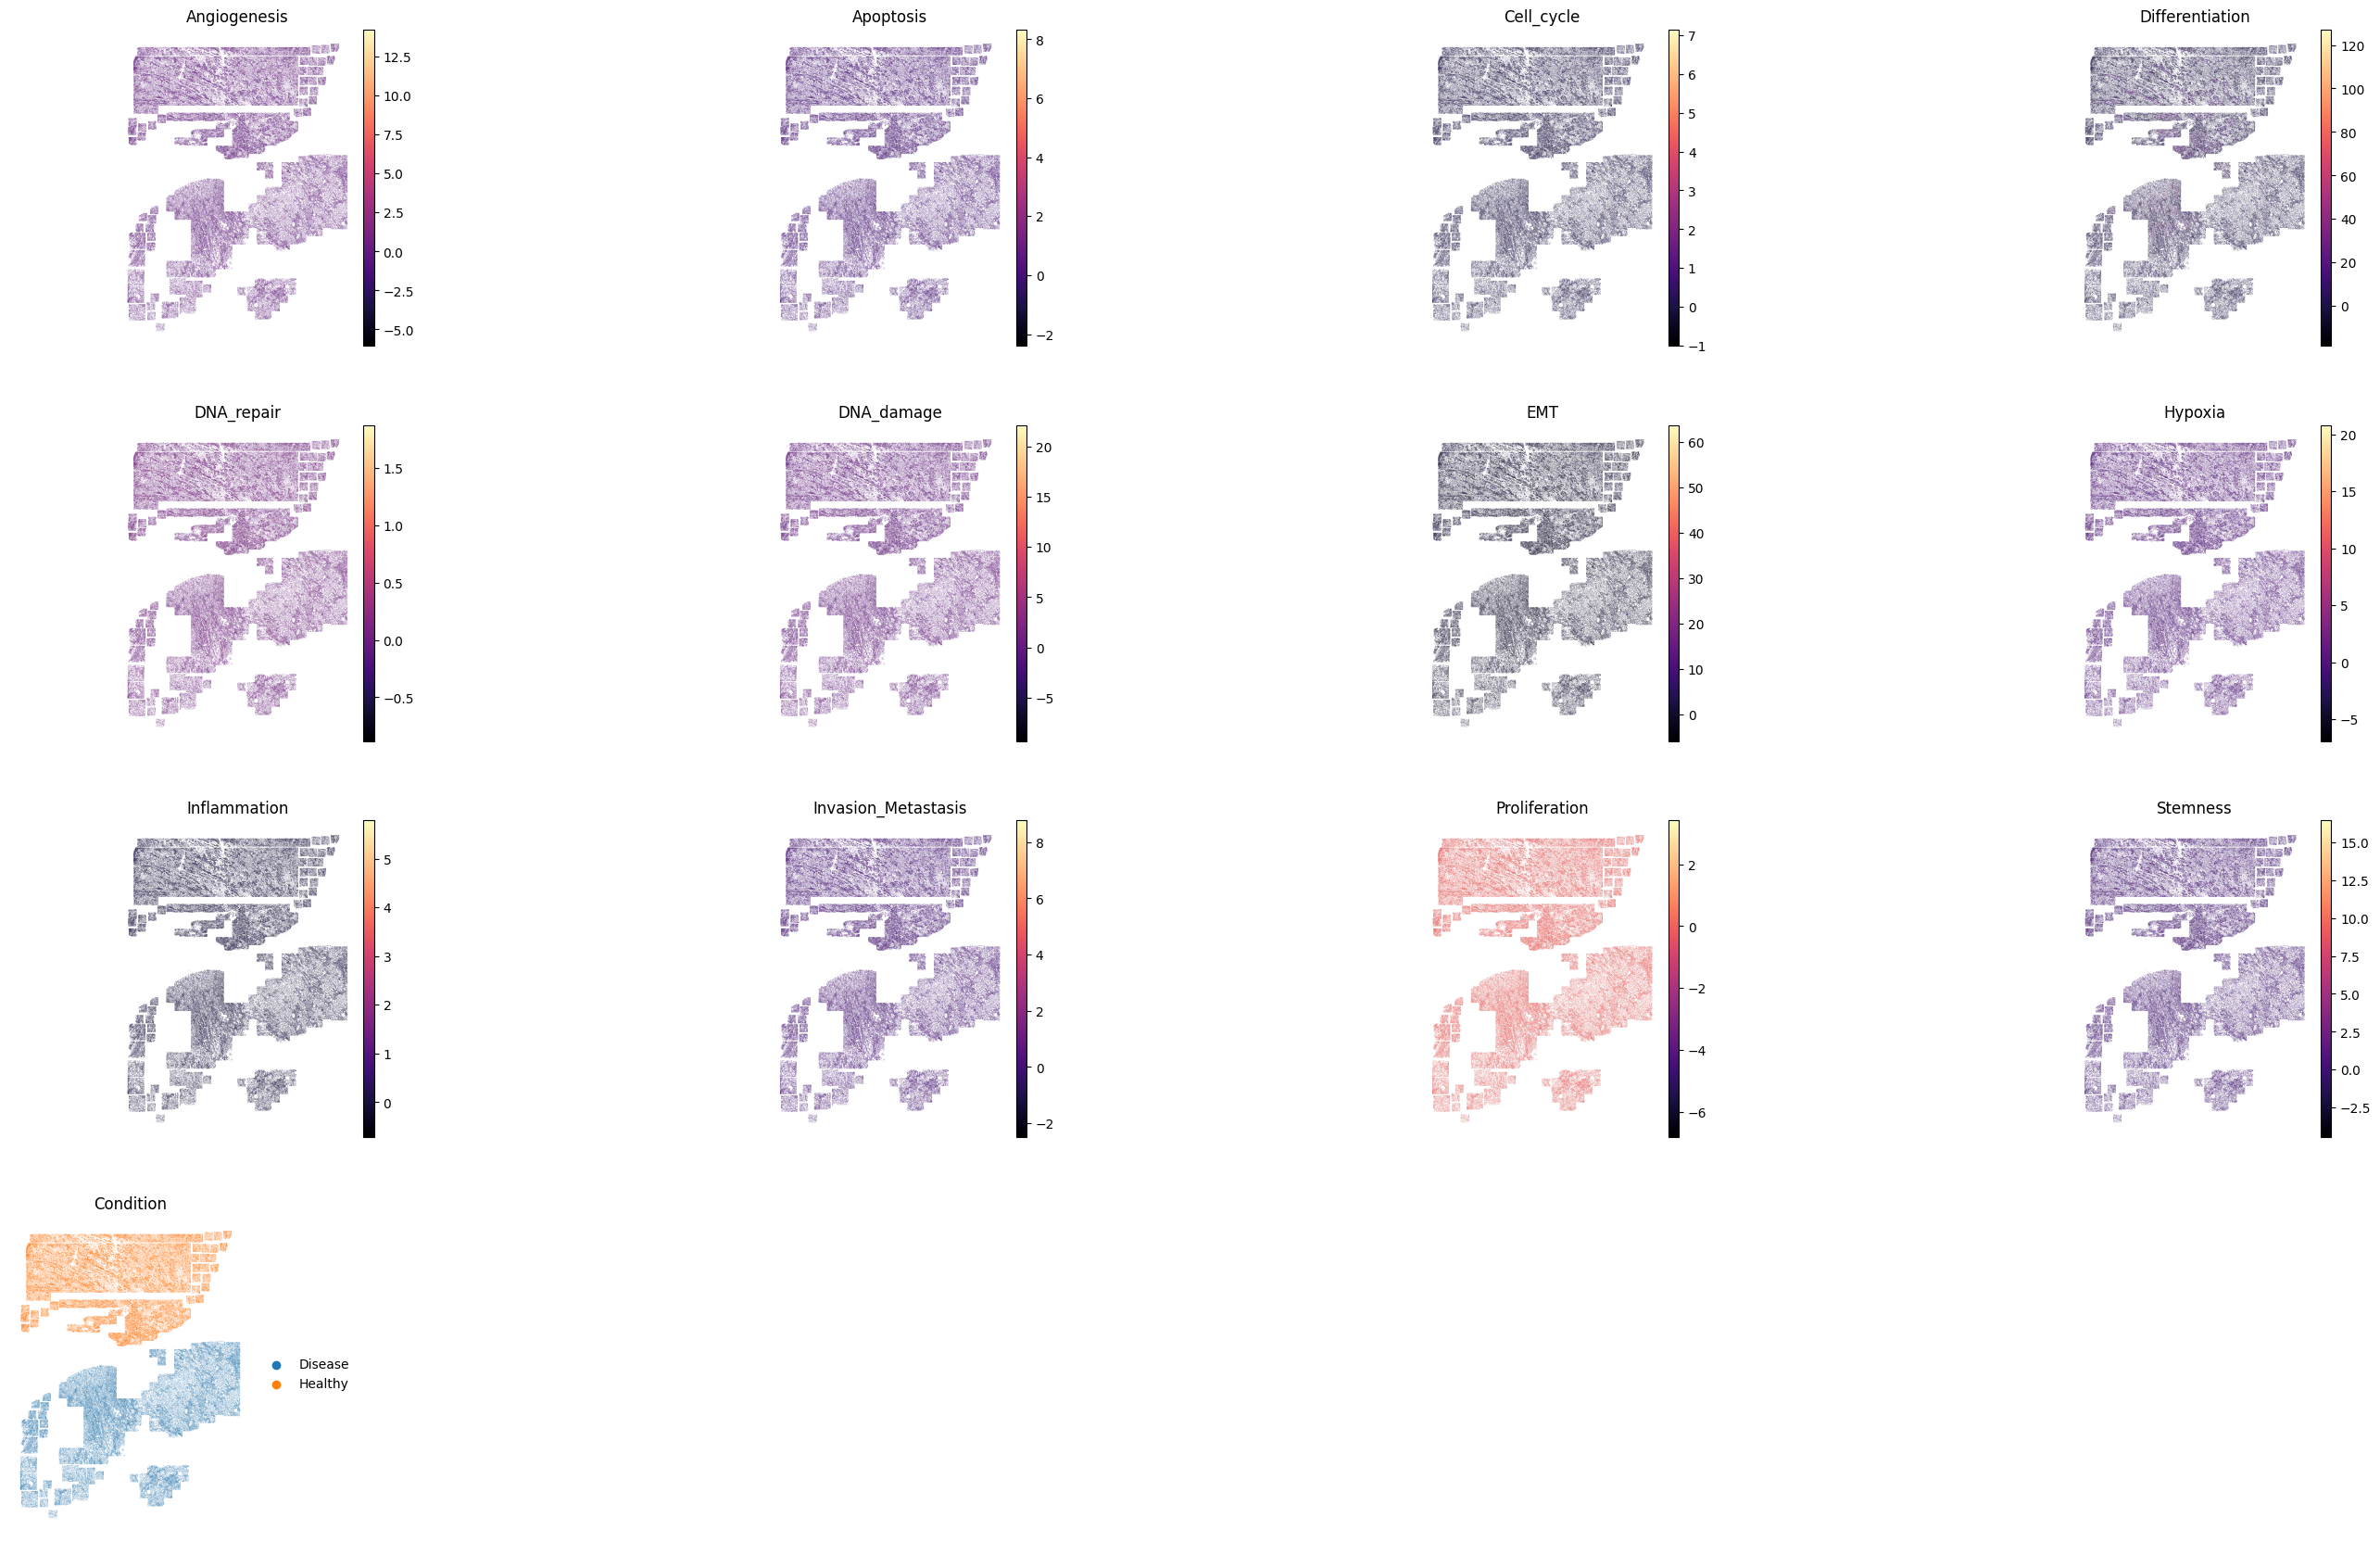

In [18]:
import scanpy as sc

# Reset global params just in case
plt.rcParams.update(plt.rcParamsDefault)

sc.pl.spatial(
    adata,
    color=available_states + ['type'],
    title=available_states + ['Condition'],
    spot_size=0.01,

    # COLORS: Use 'plasma' or 'viridis'.
    # Since the background is white, 'Reds' or 'coolwarm' might look cleaner than 'plasma'
    cmap='magma',

    wspace=0.3,
    ncols=4,

    # FORCE WHITE BACKGROUND
    frameon=False,  # Removes box around plot
    colorbar_loc='right'
)


Computing Trajectory (Diffusion Pseudotime)...


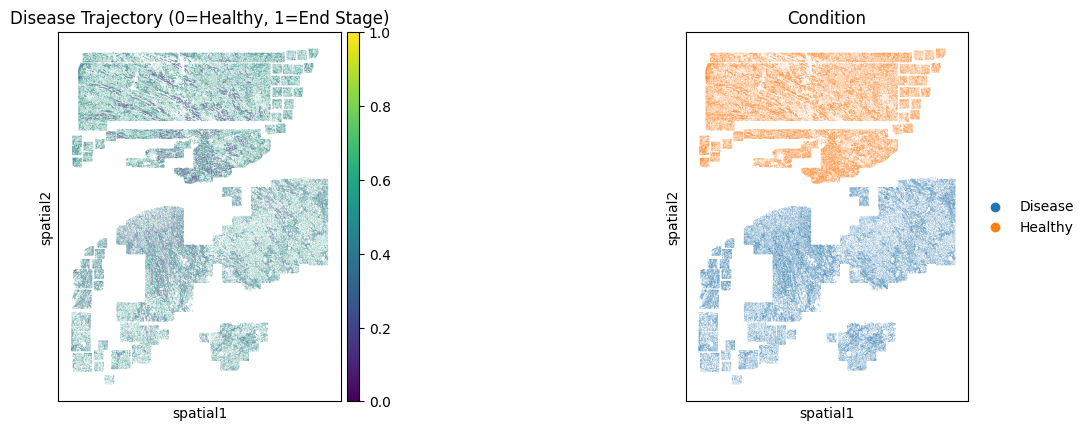

In [14]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

# A. Setup: Choose a root cell (A perfectly healthy Proximal Tubule cell)
# We find a cell with high 'Differentiation' score and low 'EMT' score
# to act as the "Start" of the timeline.
adata.uns['iroot'] = np.flatnonzero(
    (adata.obs['type'] == 'Healthy') &
    (adata.obs['Differentiation'] > adata.obs['Differentiation'].quantile(0.9))
)[0]

# B. Calculate Pseudotime (The "Clock")
print("Computing Trajectory (Diffusion Pseudotime)...")
# Ensure neighbors are computed
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca')
sc.tl.diffmap(adata)  # Compute diffusion map
sc.tl.dpt(adata)      # Compute pseudotime (dpt_pseudotime)

# C. Visualize the Timeline Spatially
# Light Blue = Early (Healthy), Dark Blue/Red = Late (Disease endpoint)
sc.pl.spatial(
    adata,
    color=['dpt_pseudotime', 'type'],
    title=['Disease Trajectory (0=Healthy, 1=End Stage)', 'Condition'],
    cmap='viridis',
    spot_size=0.01,
    wspace=0.3
)


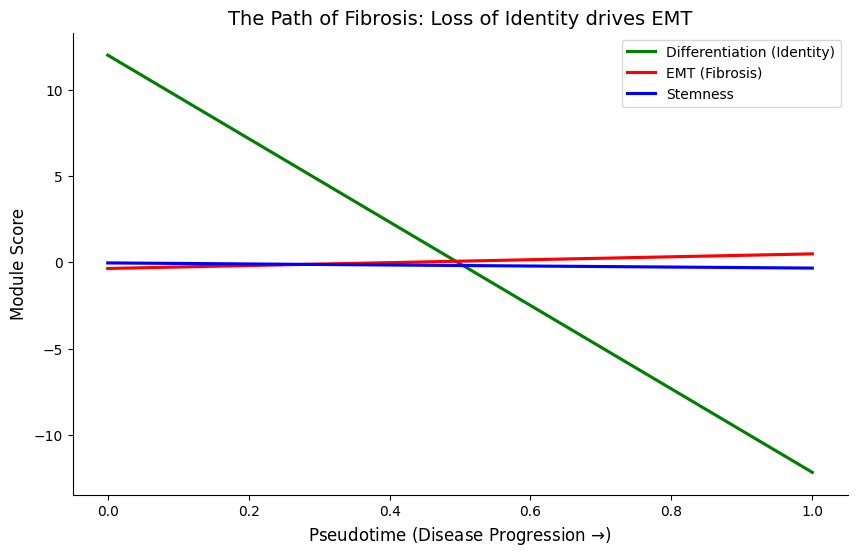

In [15]:
# Create a DataFrame for plotting
traj_df = adata.obs[['dpt_pseudotime',
                     'Differentiation', 'EMT', 'Stemness', 'type']].copy()

# Sort by time for clean lines
traj_df = traj_df.sort_values('dpt_pseudotime')

# Plot the Dynamics
fig, ax = plt.subplots(figsize=(10, 6))

# Smooth lines for the trends
sns.regplot(data=traj_df, x='dpt_pseudotime', y='Differentiation',
            scatter=False, label='Differentiation (Identity)', color='green', ax=ax)
sns.regplot(data=traj_df, x='dpt_pseudotime', y='EMT',
            scatter=False, label='EMT (Fibrosis)', color='red', ax=ax)
sns.regplot(data=traj_df, x='dpt_pseudotime', y='Stemness',
            scatter=False, label='Stemness', color='blue', ax=ax)

# Styling
ax.set_xlabel("Pseudotime (Disease Progression $\u2192$)", fontsize=12)
ax.set_ylabel("Module Score", fontsize=12)
ax.set_title("The Path of Fibrosis: Loss of Identity drives EMT", fontsize=14)
ax.legend()
sns.despine()
plt.show()


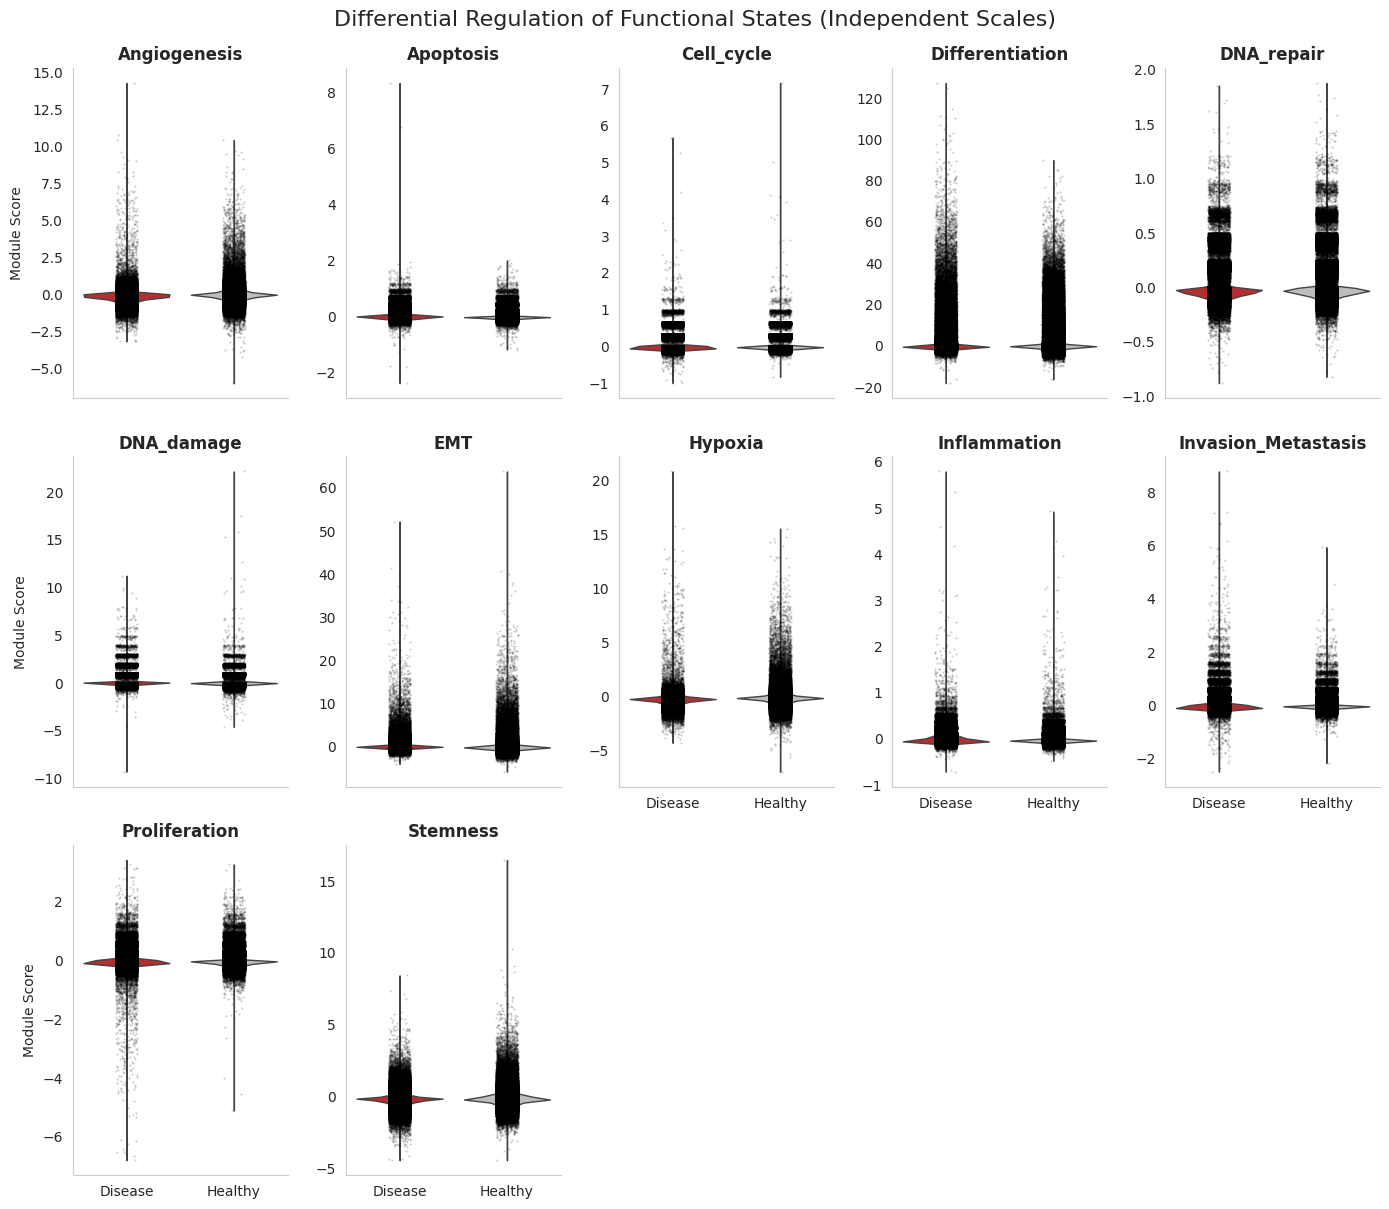

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set clean white theme
sns.set_style("whitegrid")
plt.rcParams['axes.grid'] = False  # Turn off grid for cleaner look

# 1. Setup the FacetGrid (Grid of plots)
g = sns.catplot(
    data=melted_df,     # Your melted dataframe
    x='type',           # X-axis: Condition
    y='Score',          # Y-axis: Score
    col='Pathway',      # Create a separate plot for each Pathway
    col_wrap=5,         # 5 plots per row
    kind='violin',      # Main plot type
    sharey=False,       # <--- MAGIC FIX: Each plot gets its own Y-axis scale
    height=4,
    aspect=0.7,
    palette={'Healthy': '#bdbdbd', 'Disease': '#cb181d'},
    cut=0,              # Don't plot below 0
    inner=None,         # Remove inner bars to make room for dots
    linewidth=1
)

# 2. Overlay the dots (Strip Plot) so you can see individual cells
g.map_dataframe(
    sns.stripplot,
    x='type',
    y='Score',
    color='black',
    alpha=0.2,          # Transparency is key for overlapping dots
    size=1.5,           # Small dots
    jitter=True         # Spread them out
)

# 3. Clean up the labels
g.set_titles("{col_name}", size=12, fontweight='bold')  # Bold titles
g.set_axis_labels("", "Module Score")
g.fig.suptitle(
    'Differential Regulation of Functional States (Independent Scales)', y=1.02, fontsize=16)

plt.show()


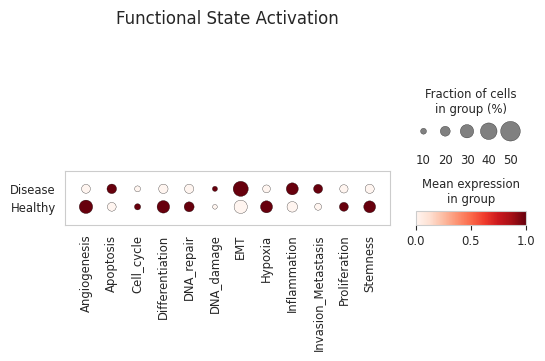

In [17]:
import scanpy as sc

# 1. Make sure your scores are in adata.obs (which they are)
pathways_to_plot = valid_categories

# 2. Standard Dot Plot
sc.pl.dotplot(
    adata,
    var_names=pathways_to_plot,  # The scores to plot
    groupby='type',              # Compare Healthy vs Disease
    standard_scale='var',        # Scale 0-1 so small pathways look as bright as big ones
    cmap='Reds',                 # Red color
    dot_max=0.5,                 # Adjust dot size scaling
    dendrogram=True,             # Cluster similar pathways together
    title="Functional State Activation"
)
